# Calculating FOMs in LUMERICAL for a photonic crystal slab

Author: Beñat Martinez de Aguirre

## Imports

Some global variables to be used during the code:

In [45]:
global c
c=3e8 #speed of light

First, we want to make sure that we can access the Lumerical's python and its packages. Then we can import `lumapi`

In [46]:
import sys, os

sys.path.append("/opt/lumerical/v212/api/python/")  # Default windows lumapi path
sys.path.append("/opt/lumerical/v212/api/")
sys.path.append("/opt/lumerical/v212/bin/")
sys.path.append("/home/bmda/anaconda3/envs/pmp/lib/python3.9/site-packages/")

import lumapi

We also want to import some stuff that will be useful later, to run processes, plot, etc.

In [47]:
import subprocess

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("science")
mpl.rcParams.update({"font.size": 28})

Now, we will create some functions that will be able to create .fsp files that are then run by `Lumerical`.

## Setting up the FDTD simulation

First, we want to let `Lumerical` know that we will run a `FDTD` calculation and with how many processes we want run it:

In [48]:
fdtd = lumapi.FDTD(hide=True)
fdtd.setresource("FDTD", 1, "processes", "4")  # We use 4 processes

## Creating the simulation area

To define our simulation we need to define the physical boundaries of the simulation as well as the time that the simulation will span across. Also important is the `mesh accuracy`, which is defined as a number from 1 to 5. When using the auto non-uniform mesh, the mesh accuracy setting of 2 which corresponds to 10 mesh points per wavelength is considered reasonable for the FDTD method, and mesh accuracy 4 or 5 which corresponds to 18 or 22 mesh points per wavelength is considered high accuracy.

In [49]:
wSimVolXY = 3e-6 #length of simulation volume in XY plane
wSimVolZ = 10e-6 #height of simulation volume
timefactor = 300 #time of simulation in units of time that it takes the simulation to cross the volume for the simulation
meshacc = 2  #mesh accuracy

In [50]:
def define_simulation_volume(wSimVolXY, wSimVolZ, meshacc, timefactor, i):
    """
    This function defines the volume of the simulation an the boundary conditions.
    @wSimVolXY: simulation volume lenght in XY directions
    @wMarginXY: empty space left at the end of simulation volume
    @ meshacc: mesh accuracy as described above
    @ timefactor: time for the simulation, in units of time that it takes to cross the simulation volume
    @ i: dipole orientation: [0,1,2] -> [X,Y,Z]
    """
    FDTD_dom = fdtd.addfdtd()
    FDTD_dom["mesh accuracy"] = meshacc
    FDTD_dom["mesh refinement"] = "conformal variant 1"  # Will see how this goes
    FDTD_dom["simulation time"] = wSimVolXY / c * timefactor
    FDTD_dom["z min"] = -wSimVolZ
    FDTD_dom["z max"] = wSimVolZ
    FDTD_dom["x min"] = -wSimVolXY
    FDTD_dom["y min"] = -wSimVolXY
    FDTD_dom["x max"] = wSimVolXY
    FDTD_dom["y max"] = wSimVolXY
    FDTD_dom["auto shutoff min"] = 1e-99  # so it finishes the simulations

    fdtd.select("FDTD")

    fdtd.set("x min bc", "Symmetric")
    fdtd.set("y min bc", "Symmetric")
    fdtd.set("z min bc", "Symmetric")

    if i == 0:

        fdtd.set("x min bc", "Anti-Symmetric")
    elif i == 1:
        fdtd.set("y min bc", "Anti-Symmetric")
    else:  # i == 2
        fdtd.set("z min bc", "Anti-Symmetric")

Note that we did not add any boundary conditions! We did not because this is the default for `Lumerical`.

## Design of Photonic Crystal Slab

We will define the geometry of our simulation. We start by defining a function that tells us where the centers of the holes in the PhC slab are:

In [51]:
aPhC = 380e-9
wMarginXY = 0.5e-6

In [52]:
def define_center_holes(aPhC, wSimVolXY, wMarginXY):
    """
    This function defines the center of the holes in the PhC.
    @aPhC: lattice constant of the crystal
    @wSimVolXY: simulation volume lenght in XY directions
    @wMarginXY: empty space left at the end of simulation volume
    """

    # We define the primitive lattice vectors

    a1 = aPhC * np.array([1, 0])
    a2 = aPhC * np.array([-0.5, 0.5 * np.sqrt(3)])
    a3 = aPhC * np.array([-0.5, -0.5 * np.sqrt(3)])

    # We prepare the simulation layout

    nPlot = int(np.ceil((wSimVolXY - wMarginXY) / aPhC))

    XX = np.array(
        np.matmul(
            np.reshape(np.linspace(0, nPlot, nPlot + 1), (nPlot + 1, 1)),
            np.ones((1, nPlot + 1)),
        )
    )

    YY = np.array(
        np.matmul(
            np.ones((nPlot + 1, 1)),
            np.reshape(np.linspace(0, nPlot, nPlot + 1), (1, nPlot + 1)),
        )
    )
    
    # We define the hole centers in the X and Y dimensions

    px1 = np.reshape(a1[0] * XX + a2[0] * YY, [(nPlot + 1) ** 2, 1])
    py1 = np.reshape(a1[1] * XX + a2[1] * YY, [(nPlot + 1) ** 2, 1])

    px1 = np.vstack([px1, np.reshape(a3[0] * XX + a2[0] * YY, [(nPlot + 1) ** 2, 1])])
    py1 = np.vstack([py1, np.reshape(a3[1] * XX + a2[1] * YY, [(nPlot + 1) ** 2, 1])])

    px1 = np.vstack([px1, np.reshape(a1[0] * XX + a3[0] * YY, [(nPlot + 1) ** 2, 1])])
    py1 = np.vstack([py1, np.reshape(a1[1] * XX + a3[1] * YY, [(nPlot + 1) ** 2, 1])])

    px1 = np.reshape(px1, len(px1))
    py1 = np.reshape(py1, len(py1))

    return px1, py1


We will check that this works by plotting where the holes would lie:

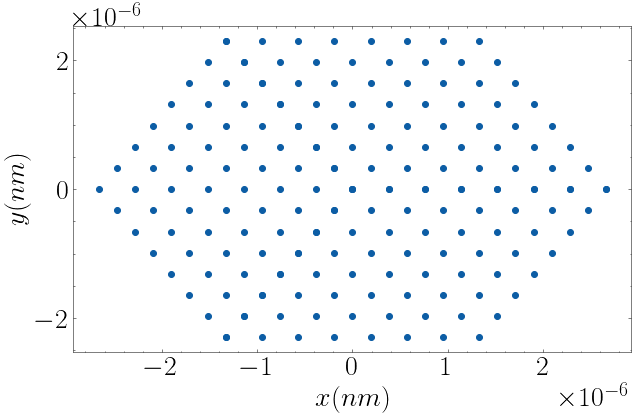

In [53]:
fig, ax = plt.subplots(figsize=(10,6))

centers = define_center_holes(aPhC,wSimVolXY, wMarginXY)
ax.set_xlabel("$x(nm)$")
ax.set_ylabel("$y(nm)$")
ax.scatter(centers[0],centers[1])

We obtain the hexagonal pattern that we were looking for! (Note that the axes are not scaled)

Now we want to create the slab and add the hexagon holes at the center positions:

In [54]:
def build_structure(aPhC, nSiN, tSiN, wSimVolXY, wMarginXY, tTether, RHole):
    """
    This function build the structure of the photonic crystal.
    @aPhC: lattice constant of the crystal
    @nSiN: refractive index of SiN
    @tSiN: thickness of the photonic crystal structure 
    @wSimVolXY: simulation volume lenght in XY directions
    @wMarginXY: empty space left at the end of simulation volume
    @tTether: lenght of the tether as described in PNAS paper
    @RHole: Radius of the inscribed circle in the hexagonal holes
    """
    # 1. We add the PhCS without holes

    rect = fdtd.addrect()
    rect["name"] = "Dplate"
    rect["index"] = nSiN
    rect["x span"] = 2 * wSimVolXY  # + 2e-6
    rect["y span"] = 2 * wSimVolXY  # + 2e-6
    rect["z min"] = -0.5 * tSiN
    rect["z max"] = 0.5 * tSiN

    # 2. We create the hexagonal area where the holes sit

    nPlot = int(np.ceil((wSimVolXY - wMarginXY) / aPhC))

    base = fdtd.addpoly()
    base["name"] = "DHexSiNBase"
    base["index"] = nSiN
    base["z span"] = tSiN
    base["x"] = 0
    base["y"] = 0
    base["vertices"] = (
        nPlot
        * aPhC
        * np.array(
            [
                [1, 0.5, -0.5, -1, -0.5, 0.5],
                [
                    0,
                    0.8660254037844386,
                    0.8660254037844386,
                    0,
                    -0.8660254037844386,
                    -0.8660254037844386,
                ],
            ]
        )
    )

    # We get the parameters/shape for the holes
    if (aPhC - tTether) > 1e-9:
        # RHole = (aPhC - tTether) / np.sqrt(3)
        # We get the 6 vertices of the holes
        thihole = np.pi / 3 * np.linspace(0, 5, 6) + np.pi / 6 * np.ones(6)
        pHoleX = RHole * np.cos(thihole)
        pHoleY = RHole * np.sin(thihole)

    # We get the hole centers

    px1, py1 = define_center_holes(aPhC, wSimVolXY, wMarginXY)

    # INDEX SEARCH FOR HOLE MODIFICATION
    stol = 1e-9
    # Tolerance
    indH0 = np.argwhere(np.abs(px1 ** 2 + py1 ** 2) < stol ** 2)  # Center hole
    indH1 = np.argwhere(
        (np.abs(px1 ** 2 + py1 ** 2) > (aPhC - stol) ** 2)
        & (np.abs(px1 ** 2 + py1 ** 2) < (aPhC + stol) ** 2)
    )  # Nearest neighbor holes : i.e. first ring of holes
    indHN = np.argwhere(
        np.abs(px1 ** 2 + py1 ** 2) > (aPhC + stol) ** 2
    )  # Rest of holesp

    # In the first approximation we will not modify the shape or position of any hole.
    # Center hole
    center_hole = fdtd.addpoly()
    center_hole["name"] = "DHexHole" + str(indH0[0])
    center_hole["index"] = 1.0
    center_hole["x"] = px1[indH0]  # x is phc propagation direction
    center_hole["y"] = py1[indH0]  #
    center_hole["z span"] = tSiN
    # vertMod = (RHole + dR0) * np.array([np.cos(thihole), np.sin(thihole)])
    center_hole["vertices"] = np.transpose([pHoleX, pHoleY])

    # First NN holes
    for j in range(1, len(indH1)):
        NN_hole = fdtd.addpoly()
        NN_hole["name"] = "DHexHole" + str(indH1[j])
        NN_hole["index"] = 1.0  # This is hole
        xUse = px1[indH1[j]]
        yUse = py1[indH1[j]]
        # pos_array = np.array([xUse, yUse])
        # posMod = pos_array + dp1 * pos_array / np.norm(pos_array)
        NN_hole["x"] = xUse  # x is phc propagation direction
        NN_hole["y"] = yUse  #
        NN_hole["z span"] = tSiN
        # vertMod = (RHole + dR1) * np.array([np.cos(thihole), np.sin(thihole)])
        NN_hole["vertices"] = np.transpose([pHoleX, pHoleY])

    # The 'normal' holes
    for j in range(1, len(indHN)):
        normal_hole = fdtd.addpoly()
        normal_hole["name"] = "DHexHole" + str(indHN[j])
        normal_hole["index"] = 1.0  # This is hole
        normal_hole["x"] = px1[indHN[j]]  # x is phc propagation direction
        normal_hole["y"] = py1[indHN[j]]  #
        normal_hole["z span"] = tSiN
        normal_hole["vertices"] = np.transpose([pHoleX, pHoleY])

## Adding sources to our simulation

Now we will add the sources to the simulation. The FDTD method is commonly employed to compute transmission and
reflection spectra, much like the frequency-domain response. Unlike solvers for a frequency-domain response, however, time-domain methods can compute the response of a linear system at many frequencies with
a single computation. The trick is to take the Fourier transform of the response
to a short pulse. 

But of course, because of the Fourier uncertainty principle a more frequency resolved spectral feature will require more time, given the steady-state response of the system is achieved.

In this example, we will use a dipole source with a bandwidth to extract the spectral features of our system. For reference on the dipole source, please check: https://support.lumerical.com/hc/en-us/articles/360034382794-Dipole-source-Simulation-object

In [55]:
def define_sources(px1,py1, i, freqhighres):
    """
    This defines the sources to be used in the simulation.
    @px1: X coordinates of the hole centers.
    @py1: Y coordinates of the hole centers
    @ i: dipole orientation: [0,1,2] -> [X,Y,Z]
    @freqhighres: Sampling resolution of the frequency 
    """
    freq = 351.726e12
    bandwidth = 250e12 

    # The sampling resolution should not be confused by the frequency resolution that is determined by the
    # Fourier transform and the simulation time. This will give us the real resolution, which we later sample
    # with the sampling resolution!

    # For use as input into the DipolePower() and SourcePower()
    fUse = (
        freq
        - 0.5 * bandwidth
        + bandwidth * np.linspace(0, (freqhighres - 1), freqhighres) / (freqhighres - 1)
    )

    dipole_source = fdtd.adddipole()
    dipole_source["name"] = "DSource"

    # Now we will get the position of the central hole:

    stol = 1e-9
    indH0 = np.argwhere(np.abs(px1 ** 2 + py1 ** 2) < stol ** 2)  # Center hole

    dipole_source["x"] = px1[indH0[0]]  
    dipole_source["y"] = py1[indH0[0]] 
    dzDP = 0.0 # Z displacement of atom in simulation volume 
    dipole_source[
        "z"
    ] = dzDP  # This is how much the dipole is displaced on the Z axis, if it cannot be trapped correctly
    
    dipole_source["set frequency"] = 1 # This makes it possible to either set the frequency or the wavelength and choose to either set the center and span or the minimum and maximum frequencies of the source.
    dipole_source["override global source settings"] = True
    dipole_source["center frequency"] = freq
    dipole_source["frequency span"] = bandwidth
    dipole_source["optimize for short pulse"] = True

    # Normalize for injected power source:

    fdtd.cwnorm(1)  # Normalized to the first active source
    dipole_source["record local field"] = 1 # Gives better results for Purcell Factor calculations, etc.

    thi = [90, 90, 0]
    phi = [0, 90, 0]

    fdtd.select("DSource")
    fdtd.set("theta", thi[i])
    fdtd.set("phi", phi[i])
    

## Adding monitors for measurement

Finally, we want to add monitors to perform measurements. As a matter of fact, to calculate the Purcell factor we need to be able to know the power of the dipole, and to calculate the emission into radiation modes we need to define the boxes that will measure the power that goes through them:

In [56]:
def add_monitors(freqhighres):
    """
    This function adds the monitors to measure the fields/power in the simulation.
    @freqhighres: Sampling resolution of the frequency 
    """
    #  Field at dipole position

    # 1) Field on dipole source location for Green function

    profile = fdtd.addpower()
    profile["name"] = "profile"
    profile["monitor type"] = "2D Z-normal"
    profile["x"] = 0
    profile["y"] = 0
    profile["z"] = 0
    profile["x min"] = -wSimVolXY
    profile["x max"] = +wSimVolXY
    profile["x span"] = 2 * wSimVolXY
    profile["y min"] = -wSimVolXY
    profile["y max"] = +wSimVolXY
    profile["y span"] = 2 * wSimVolXY
    profile["override global monitor settings"] = 1
    profile["frequency points"] = freqhighres

    # We set power monitor for radiation losses

    # Parameters computed from convergence test

    L_rad = 4 * aPhC  # Normally 14
    h_rad = 4e-6 #0.85e-6
    w_rad = 2e-6 #0.5e-6

    profile1 = fdtd.addpower()
    profile1["name"] = "profile_prime1"
    profile1["monitor type"] = "2D Z-normal"
    profile1["x"] = 0
    profile1["y"] = 0
    profile1["z"] = h_rad
    profile1["x min"] = -L_rad
    profile1["x max"] = +L_rad
    profile1["x span"] = 2 * L_rad
    profile1["y min"] = -L_rad
    profile1["y max"] = +L_rad
    profile1["y span"] = 2 * L_rad
    profile1["override global monitor settings"] = 1
    profile1["frequency points"] = freqhighres

    profile2 = fdtd.addpower()
    profile2["name"] = "profile_prime2"
    profile2["monitor type"] = "2D Y-normal"
    profile2["x"] = 0
    profile2["y"] = L_rad
    profile2["z"] = h_rad - 0.5 * w_rad
    profile2["x min"] = -L_rad
    profile2["x max"] = +L_rad
    profile2["x span"] = 2 * L_rad
    profile2["z min"] = h_rad - w_rad
    profile2["z max"] = h_rad
    profile2["z span"] = w_rad
    profile2["override global monitor settings"] = 1
    profile2["frequency points"] = freqhighres

    profile3 = fdtd.addpower()
    profile3["name"] = "profile_prime3"
    profile3["monitor type"] = "2D X-normal"
    profile3["x"] = L_rad
    profile3["y"] = 0
    profile3["z"] = h_rad - 0.5 * w_rad
    profile3["y min"] = -L_rad
    profile3["y max"] = L_rad
    profile3["y span"] = 2 * L_rad
    profile3["z min"] = h_rad - w_rad
    profile3["z max"] = h_rad
    profile3["z span"] = w_rad
    profile3["override global monitor settings"] = 1
    profile3["frequency points"] = freqhighres

## Make savefile

Lumerical requires a savefile to run the simulation, we just create it by assigning it a name.

In [57]:
def make_savefile(name):
    """
    This creates the fsp savefile which holds the data for the lumerical simulation.
    @name: name of the savefile
    """
    fdtd.save("lumerical-running-savefile" + str(name))

## Create fsp file

Now, we combine all of the previous functions to create the fsp file with all the simulation data within.

In [58]:
def create_fsp_file(name):    
    """
    This creates the fsp simulation file by combining the previous functions.
    @name: name of the savefile
    """
    
    wSimVolXY = 3e-6
    wSimVolZ = 10e-6
    timefactor = 300
    meshacc = 2 
    i = 0 # X orientation of dipole
    define_simulation_volume(wSimVolXY,wSimVolZ,meshacc,timefactor, i)
    nSiN = 1.997
    tSiN = 200e-9
    tTether = 180e-9
    multiplier = 0.261 * aPhC
    RHole = 2 * multiplier / np.sqrt(3)
    build_structure(aPhC, nSiN, tSiN, wSimVolXY, wMarginXY, tTether, RHole)
    freqhighres = 1000
    px1, py1 = define_center_holes(aPhC, wSimVolXY, wMarginXY)
    define_sources(px1,py1,i, freqhighres)
    add_monitors(freqhighres)
    make_savefile(name)
    

## Running the simulation

We may now create the fsp file:

In [59]:
name = "test"
create_fsp_file(name)

And then we run it using the `subprocess` library:

In [60]:
process = subprocess.Popen(
        [
            "nohup /opt/lumerical/v212/mpich2/nemesis/bin/mpiexec -n 4 /opt/lumerical/v212/bin/fdtd-engine-mpich2nem lumerical-running-savefile"
            + str(name)
            + ".fsp > output.txt </dev/null "
        ],
        shell=True,
    )  # this executes a shell command

exit_code = process.wait()  # We wait till the process is finished: in case there are processes to be run sequentially!

## Saving the results

Once we have run the simulation and the fsp has all the information of the simulation we can retrieve our results:

In [61]:
def get_results(i, name):
    """
    This functions calculates the FOMs using the fsp file.
    @name: name of the savefile
    @ i: dipole orientation: [0,1,2] -> [X,Y,Z]
    """
    fdtd = lumapi.FDTD(hide=True)
    fdtd.load("lumerical-running-savefile" + str(name))

    freq = 351.726e12
    bandwidth = 250e12  
    freqhighres = 1000  # For more detailed plots

    # For use as input into the DipolePower() and SourcePower()
    fUse = (
        freq
        - 0.5 * bandwidth
        + bandwidth * np.linspace(0, (freqhighres - 1), freqhighres) / (freqhighres - 1)
    )

    EPurcellEnhancement = np.abs(
        fdtd.dipolepower(fUse)[:, 0] / fdtd.sourcepower(fUse)[:, 0]
    )

    moment = fdtd.getdata("DSource", "moment")
    eps_0 = 8.85e-12
    c = 3e8

    # Purcell enhancement with Green's function: E field from monitor

    E_m = fdtd.getresult("profile", "E")["E"]

    G_m = (E_m * c ** 2 * eps_0) / (
        moment * (2 * np.pi * fUse[None, None, None, :, None]) ** 2
    )

    Green_function = G_m

    P_prime_1 = np.real(fdtd.getresult("profile_prime1", "power")[:, 0])
    P_prime_2 = np.real(fdtd.getresult("profile_prime2", "power")[:, 0])
    P_prime_3 = np.real(fdtd.getresult("profile_prime3", "power")[:, 0])

    P_prime = 2 * (P_prime_1 + 2 * P_prime_2 + 2 * P_prime_3)

    Purcell_rad = np.abs(P_prime / fdtd.sourcepower(fUse)[:, 0])

    return (
        Green_function,
        EPurcellEnhancement,
        Purcell_rad,
    )

We can use the previous function to save our results in files:

In [62]:
i = 0
results = get_results(i, name)

np.save("Green_functions" + name, np.array(results[0]))
np.savetxt("PurcellEnhancement" + name + ".txt", np.array(results[1]))
np.savetxt("Purcell_rad" + name + ".txt", np.array(results[2]))

## Data analysis and visualization of results

Finally, we load our results from the files and plot the Purcell Enhancement:

Max. Purcell Factor in X:  7.9617582533624915
Min. Purcell Factor in X:  0.2258972031298341


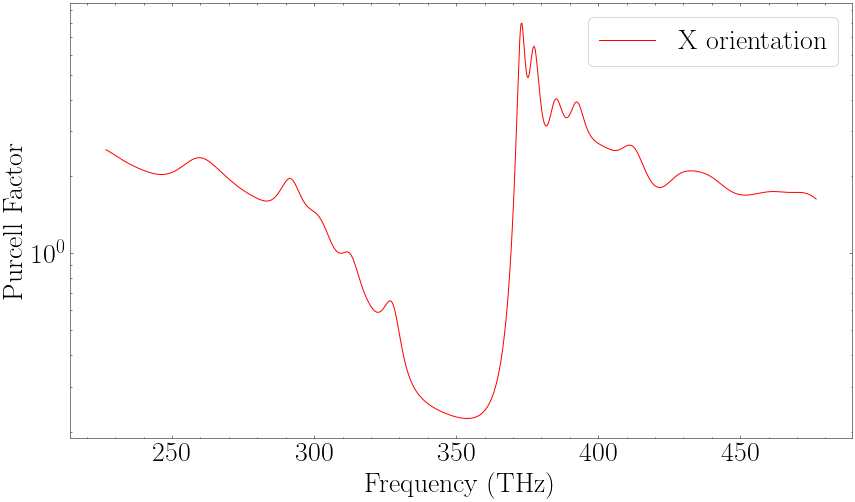

In [63]:
Purcell_X = np.loadtxt("PurcellEnhancementtest.txt")


freq = 351.726e12
bandwidth = 250e12  # This is giant. will it work?
freqhighres = 1000

# For use as input into the DipolePower() and SourcePower()
fUse = (
    freq
    - 0.5 * bandwidth
    + bandwidth * np.linspace(0, (freqhighres - 1), freqhighres) / (freqhighres - 1)
) * 10 ** -12

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(fUse, Purcell_X, color="red", label="X orientation")

ax.set_yscale("log")

ax.set_ylabel("Purcell Factor")
ax.set_xlabel("Frequency (THz)")

ax.legend(frameon=True)

print("Max. Purcell Factor in X: ", np.max(Purcell_X))
print("Min. Purcell Factor in X: ", np.min(Purcell_X))

fig.savefig("phc_purcell_factor.pdf")

We also plot the emission into the radiation modes relative to free-space emission:

Rad. emission in X for trans. freq. :  0.09719721229304397


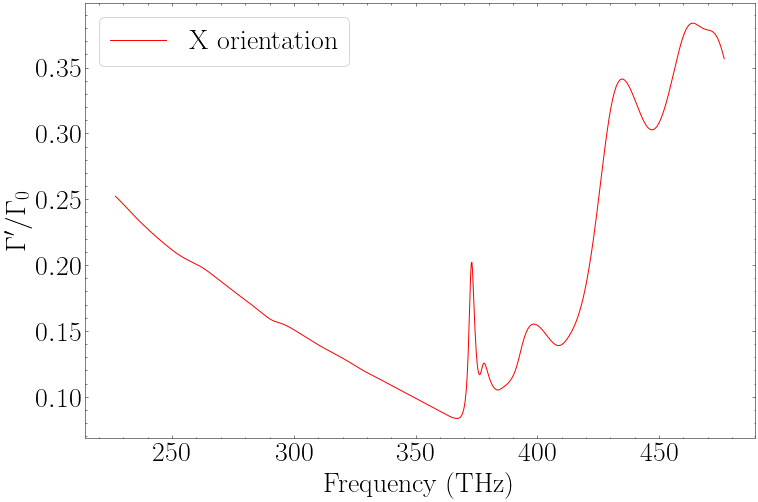

In [64]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


value = find_nearest(fUse, freq * 1e-12)
index = list(fUse).index(value)

Purcell_rad_X = np.loadtxt("Purcell_radtest.txt")


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(fUse, Purcell_rad_X, color="red", label="X orientation")
ax.legend(frameon=True,loc=0)
ax.set_ylabel("$\Gamma^\prime / \Gamma_0$")
ax.set_xlabel("Frequency (THz)")

print("Rad. emission in X for trans. freq. : ", Purcell_rad_X[index])

fig.savefig("phc_gamma_prime_gamma_0.pdf")

We can find the emission into the guided modes by subtracting: $\Gamma_{2D} = \Gamma_{\text{tot}} - \Gamma^\prime$. Subsequently, we can find the beta factor: $\beta = \Gamma_{2D} / \Gamma_\text{tot}$.

Max. beta factor X:  0.9811190759237187


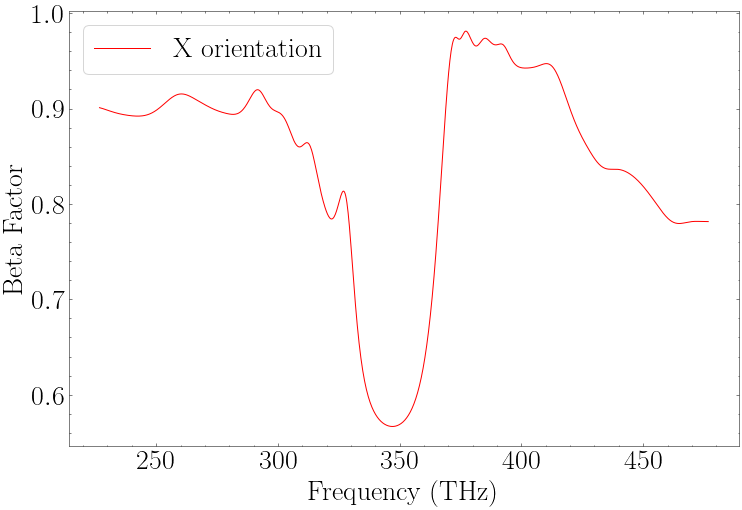

In [65]:
Purcell_1D_X = Purcell_X - Purcell_rad_X
beta_factor_X = Purcell_1D_X / Purcell_X


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(fUse, beta_factor_X, color="red", label="X orientation")



# ax.set_yscale("log")

ax.set_ylabel("Beta Factor")
ax.set_xlabel("Frequency (THz)")
ax.legend(frameon = True)
print("Max. beta factor X: ", np.max(beta_factor_X))

And lastly, we can also show one of the most important FOMs $\Gamma_{\text{2D}}/\Gamma^\prime$:

Max. Gamma2D/Gamma' in X:  51.96350941086749
Frequency for maximum:  377.12640040040037
Min. Gamma2D/Gamma' in X:  1.3079820503009068


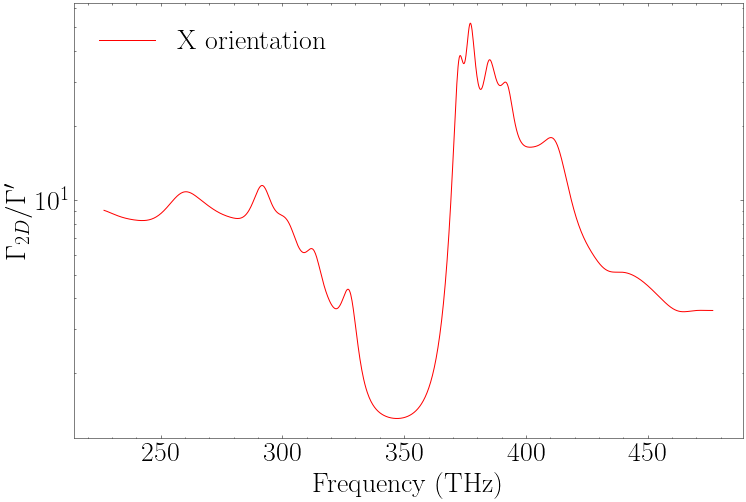

In [66]:
Gamma_1D_vs_prime_X = Purcell_1D_X / Purcell_rad_X


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(fUse, Gamma_1D_vs_prime_X, color="red", label="X orientation")

ax.set_yscale("log")

ax.set_ylabel("$\Gamma_{2D}/\Gamma^\prime$")
ax.set_xlabel("Frequency (THz)")
ax.legend()

print("Max. Gamma2D/Gamma' in X: ", np.max(Gamma_1D_vs_prime_X))
print(
    "Frequency for maximum: ",
    fUse[list(Gamma_1D_vs_prime_X).index(np.max(Gamma_1D_vs_prime_X))],
)
print("Min. Gamma2D/Gamma' in X: ", np.min(np.abs(Gamma_1D_vs_prime_X)))

fig.savefig("phc_gamma_2D_gamma_prime.pdf")